# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np
import torch.utils.data as data

from sklearn.model_selection import train_test_split
from lightning import Trainer
from torch.optim.lr_scheduler import StepLR

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    PreProcessType,
    DimReductionType,
    create_random_labels_mask_cached,
    train_test_split_by_mask,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.lenet import FullyConvolutionalLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_numbers_distribution,
    plot_epoch_generic_comparison,
    plot_epoch_generic,
    plot_masked_segmentation_comparison,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import create_model_name, report_run, read_report_to_show, lightning_metrics
from src.util.list_ext import smooth_moving_average
from src.util.dict_ext import arrange_and_repeat

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 300
scheduler_step_size = num_epochs // 10
scheduler_gamma = 0.9

In [3]:
batch_size = 32
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.NORMALIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = arrange_and_repeat(num_classes, 20)

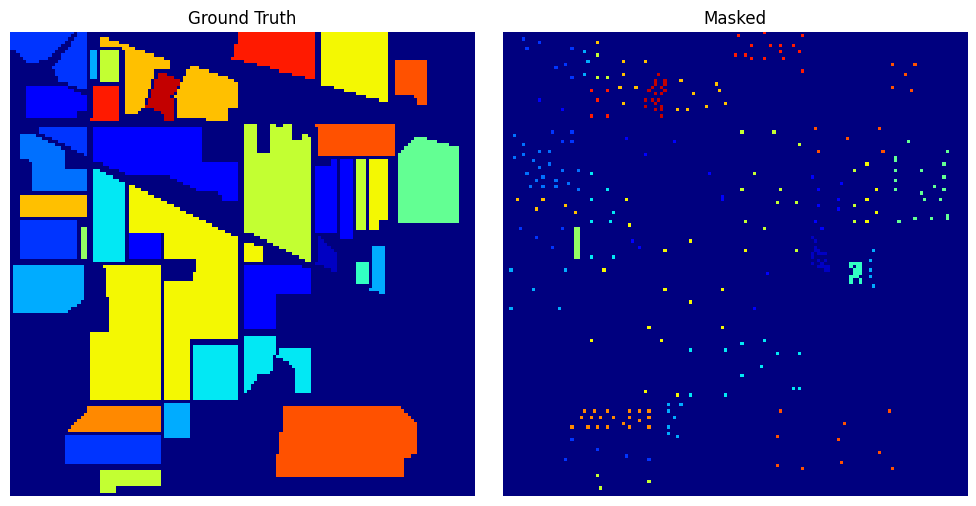

In [30]:
from src.util.hsi import read_fixed_labels_mask


mask = read_fixed_labels_mask("indian-pines-v1.npy")

x_train, y_train, x_test, y_test = train_test_split_by_mask(x, y, mask)

_ = plot_masked_segmentation_comparison(y.reshape(image_h, image_w), mask)

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [17]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [18]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

In [19]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(target_dim, num_classes),
    num_classes,
    lr=learning_rate,
    scheduler=lambda opt: StepLR(
        opt, step_size=scheduler_step_size, gamma=scheduler_gamma
    ),
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [20]:
trainer.fit(
    model,
    train_loader,
    # test_loader,
)

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | net              | FullyConvolutionalLeNet | 309 K  | train
1 | loss_fun         | CrossEntropyLoss        | 0      | train
2 | f1               | MulticlassF1Score       | 0      | train
3 | overall_accuracy | MulticlassAccuracy      | 0      | train
4 | average_accuracy | MulticlassAccuracy      | 0      | train
5 | kappa            | MulticlassCohenKappa    | 0      | train
---------------------------------------------------------------------
309 K     Trainable params
0         Non-trainable params
309 K     Total params
1.240     Total estimated model params size (MB)
18        Mo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


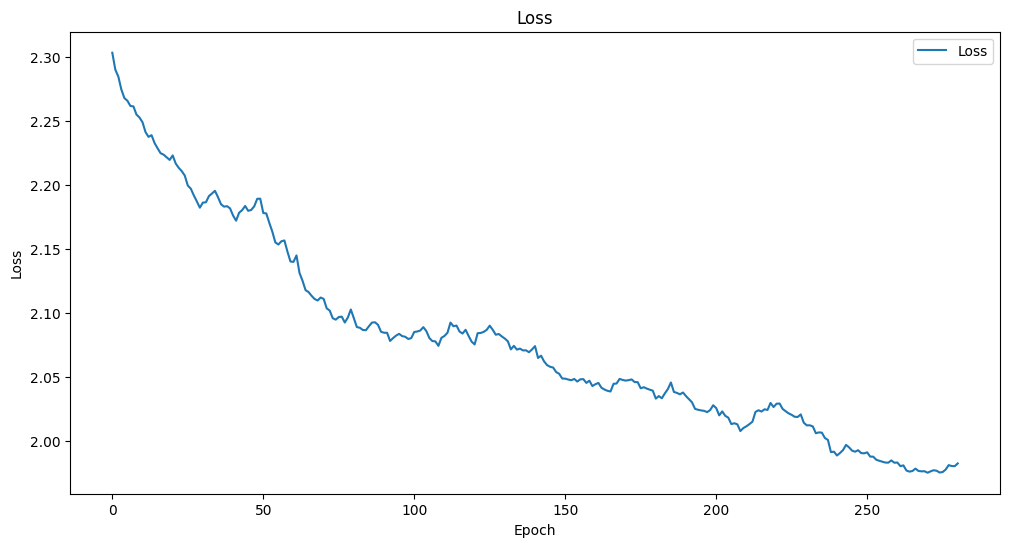

In [21]:
smothed_train = smooth_moving_average([it.loss.cpu() for it in model.train_metrics], 20)
# smothed_eval = smooth_moving_average([it.loss.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic_comparison(smothed_train, smothed_eval)

plot_epoch_generic(smothed_train)

In [22]:
# smooth_f1 = smooth_moving_average([it.f1.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic(smooth_f1)

In [23]:
validation_result = trainer.validate(model, full_loader)

validation_result

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.46677765250205994
         val_f1             0.47493231296539307
        val_kappa                   nan
        val_loss            2.5160419940948486
  val_overall_accuracy      0.2912619411945343
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.5160419940948486,
  'val_f1': 0.47493231296539307,
  'val_overall_accuracy': 0.2912619411945343,
  'val_average_accuracy': 0.46677765250205994,
  'val_kappa': nan}]

5. Display prediction

In [24]:
y_pred = trainer.predict(model, predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

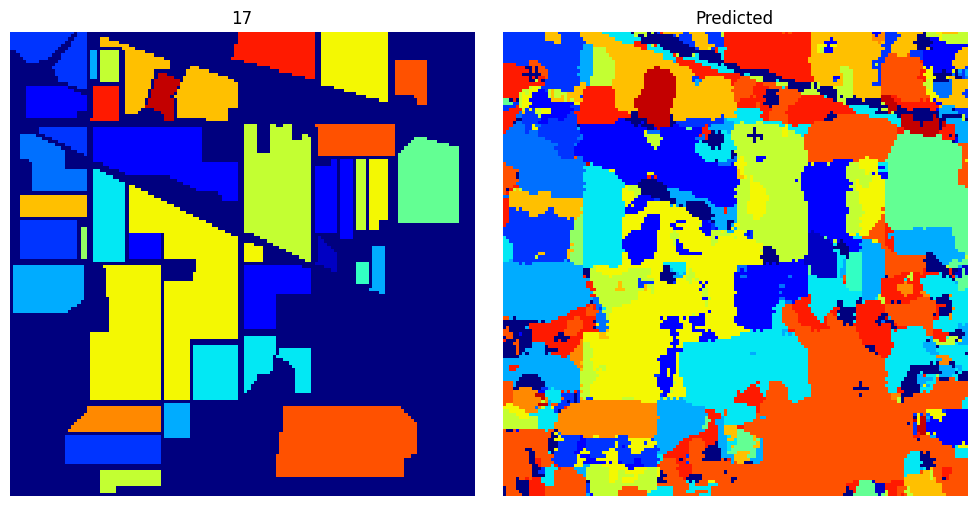

In [26]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)

6. Write report

In [27]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "lenet"

run_params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "patch_size": patch_size,
    "target_dim": target_dim,
    "pre_process_type": str(pre_process_type),
    "dim_reduction_type": str(dim_reduction_type),
}

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Fixed mask",
    run_params=run_params | model.get_params(),
    run_metrics=lightning_metrics(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__012345678910111213141516.csv')

In [28]:
read_report_to_show(model_name, sort_by_metric="f1")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
1,2025-05-29T21:35:05.336179+00:00,lenet,Fixed mask,"{""num_epochs"": 300, ""batch_size"": 32, ""patch_s...",2.516042,0.474932,0.291262,0.466778,NaN
0,2025-05-29T20:31:01.934914+00:00,lenet,Changed train ds sampling,"{""num_epochs"": 300, ""batch_size"": 32, ""patch_s...",2.521831,0.459729,0.273764,0.452699,NaN


In [29]:
read_report_to_show(model_name, sort_by_metric="OA", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
1,2025-05-29T21:35:05.336179+00:00,Fixed mask,"{""num_epochs"": 300, ""batch_size"": 32, ""patch_s...",2.516042,0.474932,0.291262,0.466778,NaN
0,2025-05-29T20:31:01.934914+00:00,Changed train ds sampling,"{""num_epochs"": 300, ""batch_size"": 32, ""patch_s...",2.521831,0.459729,0.273764,0.452699,NaN
